#環境構築<br>
①pythonのインストール<br>
②仮想環境の構築<br>
(アナコンダを利用したノートブック形式)

In [ ]:
import os
import torch
import cv2  # OpenCV
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [26]:
# --- 1. モデルのロード ---
sam_checkpoint = "sam_vit_b_01ec64.pth" # 軽量モデル
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

# ★ sam_model_registry は import されている必要があります
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# ★ SamAutomaticMaskGenerator は import されている必要があります
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    min_mask_region_area=200 
)

print("SAM model loaded successfully.")

Using device: cpu
SAM model loaded successfully.


In [27]:
# --- 2. 描画用のヘルパー関数 ---
def plot_images(stone_list, base_image, window_title_prefix):
    """
    石のリストとベース画像を受け取り、2枚の画像（輪郭・ID）を描画する
    """
    
    # ★ plt と cv2 は import されている必要があります
    
    # --- 1枚目: 輪郭のみ ---
    output_image_contours = base_image.copy()
    for stone in stone_list:
        # ★ np は import されている必要があります
        mask_uint8 = (stone['mask_data']['segmentation'] * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output_image_contours, contours, -1, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(output_image_contours)
    plt.title(f"{window_title_prefix} - Contours: {len(stone_list)} items")
    plt.axis('off')
    
    # --- 2枚目: ID表示付き ---
    output_image_with_ids = base_image.copy()
    
    # 輪郭を描画
    for stone in stone_list:
        mask_uint8 = (stone['mask_data']['segmentation'] * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output_image_with_ids, contours, -1, (255, 0, 0), 2)

    # IDを書き込む
    for stone in stone_list:
        x, y, w, h = stone['bbox']
        center_x = x + w // 2
        center_y = y + h // 2
        text = str(stone['id'])
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_color = (0, 255, 255) # 黄色
        
        (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_x = center_x - text_width // 2
        text_y = center_y + text_height // 2
        
        cv2.putText(output_image_with_ids, text, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    plt.figure(figsize=(10, 10))
    plt.imshow(output_image_with_ids)
    plt.title(f"{window_title_prefix} - IDs: {len(stone_list)} items")
    plt.axis('off')
    
    # 2枚の画像を表示
    plt.show()

print("Helper function 'plot_images' defined.")

Helper function 'plot_images' defined.


画像を読み込んでいます: pyramid_test.png
リサイズ後のサイズ: 1024x1024
SAMによる自動マスク生成を開始します...
完了しました。92個のオブジェクトが検出されました。

--- デバッグ前の初期画像 ---
ID付きの画像ウィンドウを参照してください。


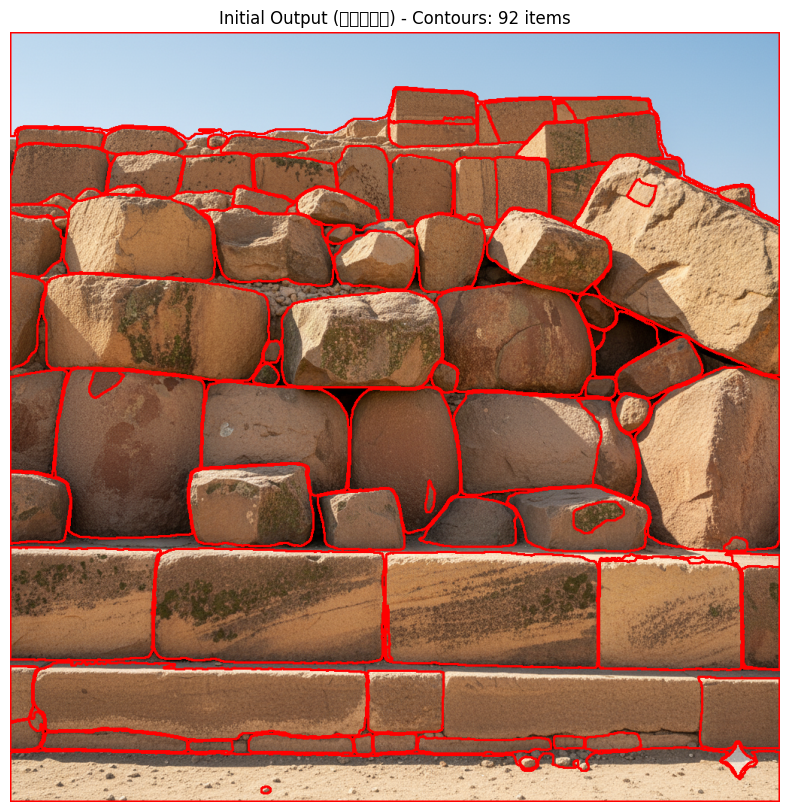

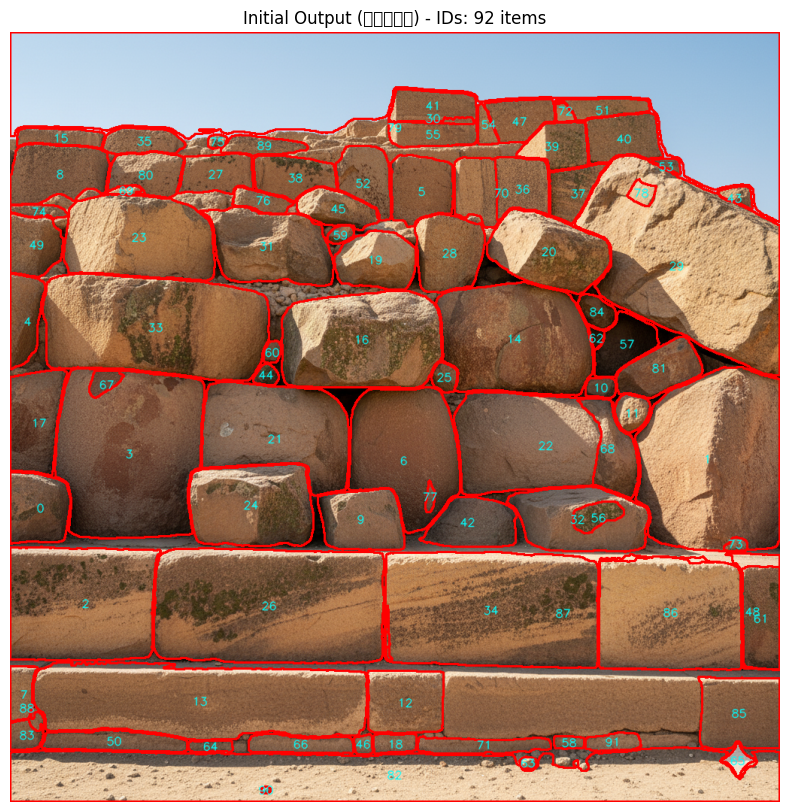


初期リストを作成しました。次のセルでデバッグを開始できます。


In [35]:
# --- 3. メインの実行関数 (SAMの実行と初期リスト作成) ---

# (このセルで使うグローバル変数を初期化)
stone_candidates = []
image_rgb_processed = None # リサイズ後の画像を保持する変数

def run_segmentation_and_create_list(image_path):
    """
    SAMを実行し、石の候補リストと処理済み画像をグローバル変数に保存する。
    """
    # グローバル変数をこの関数内で更新することを明示
    global stone_candidates, image_rgb_processed
    
    # ★ np, cv2, os は import されている必要があります
    
    # --- 3-1. SAMの実行 ---
    print(f"画像を読み込んでいます: {image_path}")
    image_bytes = np.fromfile(image_path, dtype=np.uint8)
    image_bgr = cv2.imdecode(image_bytes, cv2.IMREAD_COLOR)
    
    if image_bgr is None:
        print(f"エラー: 画像ファイルが読み込めません: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # リサイズ
    max_size = 1024
    height, width = image_rgb.shape[:2]
    if height > max_size or width > max_size:
        scale = max_size / max(height, width)
        new_width = int(width * scale)
        new_height = int(height * scale)
        image_rgb_processed = cv2.resize(image_rgb, (new_width, new_height))
    else:
        image_rgb_processed = image_rgb.copy()
        
    print(f"リサイズ後のサイズ: {image_rgb_processed.shape[1]}x{image_rgb_processed.shape[0]}")

    print("SAMによる自動マスク生成を開始します...")
    # (mask_generator はグローバルスコープで定義済みと仮定)
    outputs = mask_generator.generate(image_rgb_processed)
    
    # stone_candidates をリセット
    stone_candidates = []
    for i, mask_data in enumerate(outputs):
        stone_candidates.append({
            "id": i,
            "area": float(np.sum(mask_data['segmentation'])),
            "bbox": mask_data['bbox'],
            "mask_data": mask_data
        })
    print(f"完了しました。{len(stone_candidates)}個のオブジェクトが検出されました。")

    # --- 3-2. デバッグ前の画像を表示 ---
    if not stone_candidates:
        print("オブジェクトが検出されませんでした。")
        return

    print("\n--- デバッグ前の初期画像 ---")
    print("ID付きの画像ウィンドウを参照してください。")
    # (plot_images はグローバルスコープで定義済みと仮定)
    plot_images(stone_candidates, image_rgb_processed, "Initial Output (デバッグ前)")
    
    print("\n初期リストを作成しました。次のセルでデバッグを開始できます。")

# --- 3-X. 実行 ---
image_to_segment = "pyramid_test.png"

# (os は import されている必要があります)
if not os.path.exists(image_to_segment):
    print(f"エラー: 画像ファイルが見つかりません: {image_to_segment}")
else:
    run_segmentation_and_create_list(image_to_segment)

In [ ]:
# --- 4. インタラクティブ・デバッグ (修正版) ---

# (plot_images, np, cv2 が import 済みであること)

def start_interactive_debug():
    # グローバル変数から元のデータをコピーして使用する
    if 'stone_candidates' not in globals() or not stone_candidates:
        print("エラー: デバッグ対象の 'stone_candidates' が見つかりません。")
        print("前のセル（SAMの実行）を先に実行してください。")
        return

    # ★デバッグ作業用のリストをコピーして作成
    current_stone_list = stone_candidates.copy()
    current_image_base = image_rgb_processed.copy()
    
    print(f"デバッグを開始します。現在の石の数: {len(current_stone_list)}")
    
    while True:
        # --- 1. IDの入力 ---
        ids_to_remove_set = set()
        try:
            user_input = input("\n削除したいIDを入力してください (例: 5, 12, 30): ")
            if user_input.strip(): # 何か入力された場合のみ処理
                ids = {int(id_str.strip()) for id_str in user_input.split(',')}
                ids_to_remove_set.update(ids)
            else:
                print("IDが入力されませんでした。")
        
        except ValueError:
            print("エラー: 数値またはカンマ区切りの数値のみ入力してください。")
            continue # ループの最初に戻る
        except (EOFError, KeyboardInterrupt):
            print("\nデバッグを中断しました。")
            break

        # --- 2. リストから削除して画像を表示 ---
        if ids_to_remove_set:
            
            # ★★★ 要望点①: 削除予定のIDを列挙 ★★★
            print(f"--- 削除予定のID: {sorted(list(ids_to_remove_set))} ---")
            
            # 削除対象IDを除外した新しいリストを作成
            original_count = len(current_stone_list)
            current_stone_list = [stone for stone in current_stone_list if stone['id'] not in ids_to_remove_set]
            removed_count = original_count - len(current_stone_list)
            print(f"{removed_count}個のIDをリストから削除しました。")
            
        print(f"現在の石の数: {len(current_stone_list)}")
        print("更新された画像を表示します...")
        
        # ★★★ 要望点②: 2枚の画像を出力 ★★★
        # (plot_images は2枚（輪郭＋ID）を出力する関数)
        plot_images(current_stone_list, current_image_base, "Debugged Output")
        
        # --- 3. 継続確認 ---
        try:
            redo_choice = input("\nさらにデバッグを行いますか？ (y/n): ").strip().lower()
            if redo_choice != 'y':
                print("デバッグを終了します。")
                break # whileループを抜ける
            
        except (EOFError, KeyboardInterrupt):
            print("\nデバッグを終了します。")
            break

# --- 4-X. デバッグの実行 ---
start_interactive_debug()

デバッグを開始します。現在の石の数: 92
エラー: 数値またはカンマ区切りの数値のみ入力してください。
